# Recommender Systems with Surprise
- **Created by Andrés Segura Tinoco**
- **Created on May 27, 2019**

## Tune algorithm parameters
- Model built from a Pandas dataframe
- The algorithm used is: Singular Value Decomposition (SVD)
- Model trained using train and test datasets (80/20) and cross-validation
- The RMSE and MAE metrics were used to estimate the model error
- Type of filtering: collaborative

In [1]:
# Load the Python libraries
import os
import pandas as pd
import numpy as np
from collections import defaultdict
from sklearn.model_selection import train_test_split

In [2]:
# Load Surprise libraries
from surprise import SVD
from surprise import Reader
from surprise import Dataset
from surprise import accuracy
from surprise.model_selection import GridSearchCV

In [3]:
# Load plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
# Path to dataset file
file_path = os.path.expanduser('../data/u.data')

# Read current ratings of the users
rawdata = pd.read_csv(file_path, sep = '\t', names = ['user_id','item_id','rating','timestamp'])
rawdata.head()

,user_id,item_id,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


## 1. Manual Tune

In [5]:
# Split data in training and test
train_data, test_data = train_test_split(rawdata, test_size = 0.2)
print("Train size:", train_data.shape)    # 80.00%
print("Test size:", test_data.shape)      # 20.00%

Train size: (80000, 4)
Test size: (20000, 4)


In [6]:
# Read the data into a Surprise dataset
reader = Reader(rating_scale = (1, 5))
data_train = Dataset.load_from_df(train_data[['user_id', 'item_id', 'rating']], reader)
data_test = Dataset.load_from_df(test_data[['user_id', 'item_id', 'rating']], reader)

In [7]:
# Build full trainset
data_train = data_train.build_full_trainset()
data_test = data_test.build_full_trainset()

# Create the trainset and testset
data_trainset = data_train.build_testset()
data_testset = data_test.build_testset()

In [8]:
# Plot the model RMSE
def plot_model_rmse(xs, ys, title, x_label, y_label):
    # Set up the matplotlib figure
    fig, ax = plt.subplots(figsize = (10, 5))
    ax.plot(xs, ys, marker = 'o')
    
    for x,y in zip(xs,ys):
        label = "{:.2f}".format(y)
        plt.annotate(label, (x,y), textcoords="offset points", xytext=(0,10), ha='center')
    
    plt.title(title, fontsize = 12)
    plt.xlabel(x_label, fontsize = 10)
    plt.ylabel(y_label, fontsize = 10)
    plt.draw()

**Number of factors (k)**

In [9]:
# Factors list
k_factors = [5, 10, 25, 50, 75, 100]

In [10]:
# CV results
train_rmse = []
test_rmse = []

# Loop in which errors are calculated
for k in k_factors:
    algo = SVD(n_factors=k, n_epochs=200, biased=True, lr_all=0.005, reg_all=0, init_mean=0, init_std_dev=0.01, verbose=False)
    algo.fit(data_train)
    
    # The error of the training data is calculated and saved
    predictions = algo.test(data_trainset)
    error = accuracy.rmse(predictions, verbose = False)
    train_rmse.append(error)
    
    # The error of the testing data is calculated and saved
    predictions_test = algo.test(data_testset)
    error = accuracy.rmse(predictions_test, verbose = False)
    test_rmse.append(error)

In [11]:
# Train RMSE dataframe
error_data = {'k': k_factors, 'error': train_rmse}
pd.DataFrame(error_data)

,k,error
0,5,0.751103
1,10,0.646741
2,25,0.425342
3,50,0.203883
4,75,0.096618
5,100,0.049100


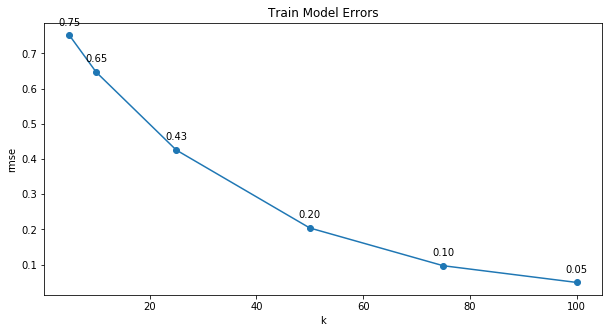

In [12]:
# Plotting the RMSE behaviour
plot_model_rmse(error_data['k'], error_data['error'], 'Train Model Errors', 'k', 'rmse')

In [13]:
# Test RMSE dataframe
error_data = {'k': k_factors, 'error': test_rmse}
pd.DataFrame(error_data)

,k,error
0,5,0.962817
1,10,1.022663
2,25,1.127359
3,50,1.143330
4,75,1.102221
5,100,1.054585


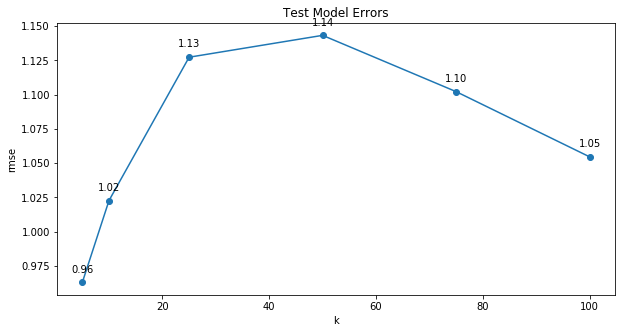

In [14]:
# Plotting the RMSE behaviour
plot_model_rmse(error_data['k'], error_data['error'], 'Test Model Errors', 'k', 'rmse')

**The regularization term for all parameters. Default is 0.02**

In [15]:
# Lista de valores de regularización
k = 5
reg_all = [0.01, 0.02, 0.05, 0.1, 0.5]

In [16]:
# CV results
train_rmse = []
test_rmse = []

# Loop in which errors are calculated
for reg in reg_all:
    algo = SVD(n_factors=k, n_epochs=200, biased=True, lr_all=0.005, reg_all=reg, init_mean=0, init_std_dev=0.01, verbose=False)
    algo.fit(data_train)
    
    # The error of the training data is calculated and saved
    predictions = algo.test(data_trainset)
    error = accuracy.rmse(predictions, verbose = False)
    train_rmse.append(error)
    
    # The error of the testing data is calculated and saved
    predictions_test = algo.test(data_testset)
    error = accuracy.rmse(predictions_test, verbose = False)
    test_rmse.append(error)

In [17]:
# Train RMSE dataframe
error_data = {'reg_all': reg_all, 'error': train_rmse}
pd.DataFrame(error_data)

,reg_all,error
0,0.01,0.756430
1,0.02,0.756207
2,0.05,0.768563
3,0.10,0.804688
4,0.50,0.938580


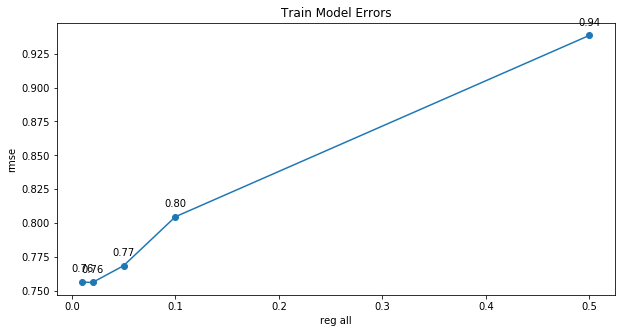

In [18]:
# Plotting the RMSE behaviour
plot_model_rmse(error_data['reg_all'], error_data['error'], 'Train Model Errors', 'reg all', 'rmse')

In [19]:
# Test RMSE dataframe
error_data = {'reg_all': reg_all, 'error': test_rmse}
pd.DataFrame(error_data)

,reg_all,error
0,0.01,0.951913
1,0.02,0.944032
2,0.05,0.917307
3,0.10,0.910624
4,0.50,0.958854


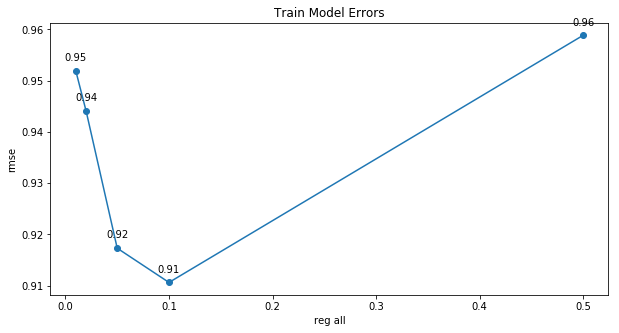

In [20]:
# Plotting the RMSE behaviour
plot_model_rmse(error_data['reg_all'], error_data['error'], 'Train Model Errors', 'reg all', 'rmse')

## 2. Auto Tune

The **GridSearchCV** class computes accuracy metrics for an algorithm on various combinations of parameters, over a cross-validation procedure. This is useful for finding the best set of parameters for a prediction algorithm.

In [21]:
# Read the raw data into a Surprise dataset
reader = Reader(rating_scale = (1, 5))
dataset = Dataset.load_from_df(rawdata[['user_id', 'item_id', 'rating']], reader)

In [22]:
# SVD params: 3 * 3 * 3 * 3 combinations
param_grid = {'n_factors': [5, 10, 20],
              'n_epochs': [20, 30, 50],
              'lr_all': [0.002, 0.005, 0.01],
              'reg_all': [0.02, 0.05, 0.1]}

In [23]:
# Tune algorithm parameters with GridSearchCV and k=4 cross-validation 
gs = GridSearchCV(SVD, param_grid, measures = ['rmse', 'mae'], cv = 4)
gs.fit(dataset)

In [24]:
# Best RMSE and MAE scores
gs.best_score

{'rmse': 0.9171767688437739, 'mae': 0.7233931478310187}

In [25]:
# Combination of parameters that gave the best scores
gs.best_params

{'rmse': {'n_factors': 20, 'n_epochs': 50, 'lr_all': 0.01, 'reg_all': 0.1},
 'mae': {'n_factors': 20, 'n_epochs': 50, 'lr_all': 0.01, 'reg_all': 0.1}}

## 3. Compute precision@k and recall@k

An item is considered relevant if its true rating $r_{ui}$ is greater than a given threshold. An item is considered recommended if its estimated rating $\hat{r}_{ui}$ is greater than the threshold, and if it is among the k highest estimated ratings.

$$ Precision@k = \frac{| TP |}{| TP + FP |} = \frac{| \{Recommended \; items \; that \; are \; relevant\} |}{| \{Recommended \; items\} |} \tag{1} $$

$$ Recall@k = \frac{| TP |}{| TP + FN |} = \frac{| \{Recommended \; items \; that \; are \; relevant\} |}{| \{Relevant \; items\} |} \tag{2} $$

In [26]:
# Return precision and recall at k metrics for each user
def precision_recall_at_k(predictions, k = 10, threshold = 3.5):
    
    # First map the predictions to each user.
    user_est_true = defaultdict(list)
    for uid, _, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))
    
    precisions = dict()
    recalls = dict()
    for uid, user_ratings in user_est_true.items():
        
        # Sort user ratings by estimated value
        user_ratings.sort(key=lambda x: x[0], reverse=True)
        
        # Number of relevant items
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)
        
        # Number of recommended items in top k
        n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])
        
        # Number of relevant and recommended items in top k
        n_rel_and_rec_k = sum(((true_r >= threshold) and (est >= threshold)) for (est, true_r) in user_ratings[:k])
        
        # Precision@K: Proportion of recommended items that are relevant
        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 1
        
        # Recall@K: Proportion of relevant items that are recommended
        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 1
    
    return precisions, recalls;

In [27]:
# Returns the precision and recall of the model at k metrics
def get_precision_vs_recall(algo, k_max = 10, verbose = False):
    precision_list = []
    recall_list = []
    
    if algo:
        for k_curr in range(1, k_max + 1):
            algo.fit(data_train)
            predictions = algo.test(data_testset)
            
            # Get precision and recall at k metrics for each user
            precisions, recalls = precision_recall_at_k(predictions, k = k_curr, threshold = 4)
            
            # Precision and recall can then be averaged over all users
            precision = sum(prec for prec in precisions.values()) / len(precisions)
            recall = sum(rec for rec in recalls.values()) / len(recalls)
            precision_list.append(precision)
            recall_list.append(recall)

            if verbose:
                print('K = ' + str(k_curr) + ' - Precision:', precision, ', Recall:', recall)
    
    return {'precision': precision_list, 'recall': recall_list};

In [28]:
# Show best params for SVD algo
gs.best_params['rmse']

{'n_factors': 20, 'n_epochs': 50, 'lr_all': 0.01, 'reg_all': 0.1}

In [29]:
# Use SVD algorithm with the best params
algo = gs.best_estimator['rmse']

In [30]:
# Calculate the precision and recall of the model at k metrics
k_max = 20
metrics = get_precision_vs_recall(algo, k_max, True)

K = 1 - Precision: 0.9225874867444327 , Recall: 0.11319023839082203
K = 2 - Precision: 0.9024390243902439 , Recall: 0.1751344358677297
K = 3 - Precision: 0.9045599151643681 , Recall: 0.2167178754410651
K = 4 - Precision: 0.890332272887946 , Recall: 0.24655148181407188
K = 5 - Precision: 0.8936196535878398 , Recall: 0.2663007091945314
K = 6 - Precision: 0.8863556026864613 , Recall: 0.27744116339742664
K = 7 - Precision: 0.8872216330858953 , Recall: 0.30317722427604316
K = 8 - Precision: 0.8906024339746497 , Recall: 0.30634643139652284
K = 9 - Precision: 0.8855055631301659 , Recall: 0.31783236995341585
K = 10 - Precision: 0.884078590785907 , Recall: 0.31856481819518023
K = 11 - Precision: 0.8851855167337674 , Recall: 0.32438713520540524
K = 12 - Precision: 0.8743211542787366 , Recall: 0.3276131478554207
K = 13 - Precision: 0.8765355182110215 , Recall: 0.3301131538891669
K = 14 - Precision: 0.8802707867129924 , Recall: 0.33149987726466834
K = 15 - Precision: 0.8781325308366665 , Recall: 0

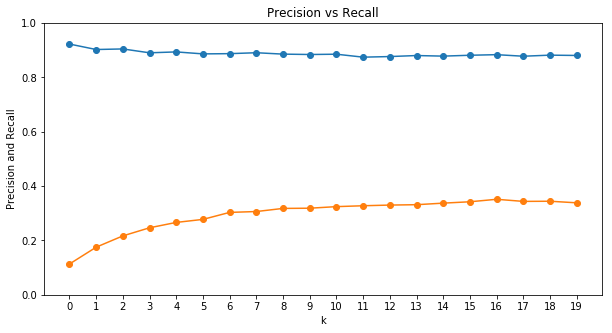

In [31]:
# Get data
c1 = metrics['precision']
c2 = metrics['recall']
x = np.arange(len(c1))

# Set up the matplotlib figure
fig, ax1 = plt.subplots(figsize = (10, 5))
plt.xticks(np.arange(min(x), max(x) + 1, 1.0))
plt.ylim(0, 1)
ax1.plot(x, c1, marker = 'o')
ax1.plot(x, c2, marker = 'o')

# Chart setup
plt.title("Precision vs Recall", fontsize = 12)
plt.xlabel("k", fontsize = 10)
plt.ylabel("Precision and Recall", fontsize = 10)
plt.draw()

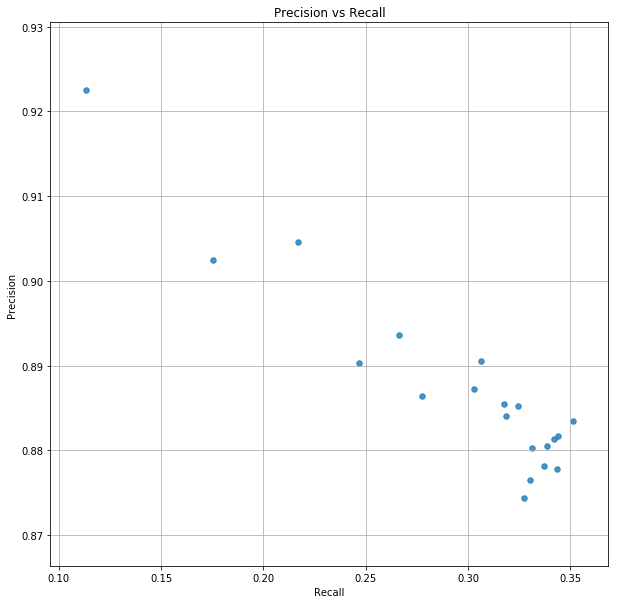

In [32]:
# Get data
x = metrics['recall']
y = metrics['precision']

# Create scatter plot with the precision and recall results
fig, ax2 = plt.subplots(figsize = (10, 10))

# Create 2D scatter plot
sns.regplot(ax = ax2, x = x, y = y, fit_reg = False, marker = "o", color = "#1f77b4", scatter_kws = {"s": 30})

# Plot setup
ax2.set_title("Precision vs Recall", fontsize = 12)
ax2.set_xlabel("Recall", fontsize = 10)
ax2.set_ylabel("Precision", fontsize = 10)
ax2.grid()

---
<a href="https://ansegura7.github.io/RS_Surprise/">&laquo; Home</a>